In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 32.2 MB/s 
     |████████████████████████████████| 948 kB 59.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ea957d3cda69994319ac73593b76fab53f8ad4d13cbebc94f4f55ddd948ad2ba
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
from numpy import vstack, hstack

import pandas as pd
import cv2
import glob
import math
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.cuda as tc

In [ ]:
class FaceMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        sub_paths = ['with_mask/', 'without_mask/', '/incorrect_mask']
        self.df = self.get_df(path, sub_paths)
        
    def get_df(self, path, sub_paths):
        paths = list()
        paths.extend(glob.glob(path + sub_paths[0] + "*.jpg"))
        labels = [1] * len(paths)
        paths.extend(glob.glob(path + sub_paths[1] + "*.jpg"))
        labels.extend([0] * (len(paths) - len(labels)))
        df = pd.DataFrame({ "path" : paths, "label" : labels})
        df = shuffle(df)
        return df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx]['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image=image)["image"]
        
        return image, label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
path = '/content/drive/MyDrive/VISIÓN ARTIFICIAL/COMPLEJO/'

fmd = FaceMaskDataset(path, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


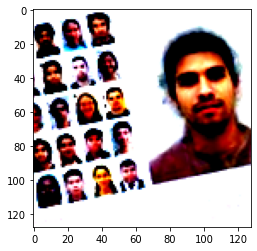

In [ ]:
plt.imshow(fmd[1][0].permute(1, 2, 0))

In [ ]:
subset = torch.utils.data.Subset(fmd, np.arange(100))

In [ ]:
dataloader = DataLoader(subset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **Implementacion**

*Convolutional*

In [ ]:
class Conv:
    def __init__(self, batch_size, channel_size, width_size, 
                 height_size, kernel_number, kernel_size=3, 
                 stride_size=1, is_input=False):
        
        self.batch_size = batch_size
        self.channel_size = channel_size
        self.width_size = width_size
        self.height_size = height_size
        self.kernel_number = kernel_number
        self.kernel_size = kernel_size
        self.stride_size = stride_size
        self.is_input = is_input
        
        self.padding_size = (kernel_size - 1) // 2
        
        self.layer = nn.Conv2d(channel_size, kernel_number, kernel_size, stride_size,
                               self.padding_size).cuda().type(torch.float32)
        
        nn.init.xavier_uniform_(self.layer.weight)

        self.delta_w = 0
        self.delta_b = 0

    def forward(self, input=tc.FloatTensor(0)):
        self.input = input
        self.act_output = self.relu(self.layer.forward(tc.FloatTensor(self.input)))
        return self.act_output

    def relu(self, xa, derive=False):
        # back prop
        if derive:
            return torch.ceil(torch.clamp(xa, min=0, max=1)).detach()
        # forward prop
        return torch.clamp(xa, min=0).detach()

    def backward(self, next_layer_grad, lr_rate=0.001, momentum_rate=0.9):
        self.act_output = torch.mul(next_layer_grad, self.relu(self.act_output, derive=True)).detach()

        # this convolution operation for calculating gradient of weights
        dw_layer = nn.Conv2d(self.batch_size, self.kernel_number, self.act_output.shape[2], 1,
                             self.padding_size).cuda().type(torch.float32)
                             
        gradx = self.act_output.clone().detach()
        # flipping for convolution operation
        gradx = gradx.cpu().detach().numpy()[:, :, ::-1, ::-1]                 
        # set weight and bias with 0  with activation gradient
        dw_layer.weight.data = tc.FloatTensor(gradx.copy()).transpose(0, 1).detach()
        del gradx
        dw_layer.bias.data = tc.FloatTensor(np.zeros(self.kernel_number)).detach()
                             
        # momentum update
        self.delta_w = momentum_rate * self.delta_w + (
                dw_layer.forward(self.input.transpose(0, 1)).transpose(0, 1).detach() / (self.batch_size)).detach()
        self.delta_b = momentum_rate * self.delta_b + (torch.sum(self.act_output, dim=[0, 2, 3]).detach() / (
                self.act_output.shape[0] * self.batch_size * self.act_output.shape[2] * self.act_output.shape[
            3])).detach()
                             
        # weight and bias update
        self.layer.weight.data -= lr_rate * self.delta_w.detach()
        self.layer.bias.data -= lr_rate * self.delta_b.detach()

        # if it is not input that initially given model then calculate input gradient as well
        if (self.is_input == False):
            # convolution operation for calculating input gradient
            dx_layer = nn.Conv2d(self.kernel_number, self.channel_size, self.kernel_size, self.stride_size,
                                 self.padding_size).cuda().type(torch.float32)
            # get weight from conv layer
            temp_weight = self.layer.weight.data.clone().cpu().numpy()
            # flip kernel for convolution operation
            temp_weightx = temp_weight[:, :, ::-1, ::-1]
            #set weight with flipped kernel
            dx_layer.weight.data = tc.FloatTensor(temp_weightx.copy()).transpose(0, 1).detach()
            #set bias with zero
            dx_layer.bias.data = tc.FloatTensor(np.zeros(self.channel_size)).detach()
            #input gradient
            out = dx_layer.forward(self.act_output)

            del temp_weight
            del temp_weightx

            return out
        else:
            #return input itself
            # del self.act_output
            return self.input

*MaxPooling*

In [ ]:
class MaxPooling:
    def __init__(self, kernel_size=2, stride_size=2):
        self.kernel_size = kernel_size
        self.stride_size = stride_size
        self.layer = nn.MaxPool2d(self.kernel_size, self.stride_size, return_indices=True).cuda().type(torch.float32)

    def forward(self, input=tc.FloatTensor(0)):
        self.input = input.detach()
        self.output, self.indices = self.layer.forward(self.input)
        return self.output

    def backward(self, next_layer_grad):
        #unpool operation for back propagation
        back_layer = nn.MaxUnpool2d(self.kernel_size, self.stride_size).cuda().type(torch.float32)
        #output of backpropagation
        out = back_layer.forward(next_layer_grad, self.indices, output_size=self.input.shape).type(
            torch.float32).detach()
        del back_layer

        return out

*Dense*

In [ ]:
class Dense:
    def __init__(self, batch_size, input_size, dense_number, is_input=False):
        self.batch_size = batch_size
        self.input_size = input_size
        self.dense_number = dense_number
        self.is_input = is_input
        #initialize weights and biases
        self.weight = tc.FloatTensor(
            np.random.normal(size=(self.input_size, self.dense_number), loc=0, scale=0.01).astype(np.float32)).type(
            torch.float32).detach()
        self.bias = tc.FloatTensor(np.zeros((1, dense_number))).type(torch.float32).detach()
        #momentum terms
        self.delta_w = 0
        self.delta_b = 0

    def forward(self, input=tc.FloatTensor(0).detach()):
        self.input = input.detach()
        self.act_output = self.relu(torch.mm(self.input, self.weight) + self.bias).detach()
        return self.act_output

    def relu(self, xa, derive=False):
        # back prop
        if derive:
            return torch.ceil(torch.clamp(xa, min=0, max=1)).detach()
        # forward prop
        return torch.clamp(xa, min=0).detach()

    def backward(self, next_layer_grad, lr_rate=0.001, momentum_rate=0.9):
        #find gradient activation functions
        self.act_output = torch.mul(next_layer_grad, self.relu(self.act_output, derive=True)).type(
            torch.float32).detach()
        #find momentum terms
        self.delta_w = momentum_rate * self.delta_w + (
                torch.mm(self.input.transpose(0, 1), self.act_output).detach() / self.batch_size).detach()
        self.delta_b = momentum_rate * self.delta_b + (
                torch.sum(self.act_output, dim=0, keepdim=True).detach() / self.batch_size).detach()
        #update weight and bias
        self.weight -= lr_rate * self.delta_w.detach()
        self.bias -= lr_rate * self.delta_b.detach()
        #check whether input is data, if it is not, then find input gradient
        if self.is_input == False:
            #gradient operation for input
            out = torch.mm(self.act_output, self.weight.transpose(0, 1)).type(torch.float32).detach()
            return out
        else:
            #return input itself
            return self.input

*Flatten*

In [ ]:
class Flatten:
    def forward(self, input=tc.FloatTensor(0).detach()):
        self.input = input.detach()
        self.batch_size = self.input.shape[0]
        self.channel_size = self.input.shape[1]
        self.width = self.input.shape[2]
        self.height = self.input.shape[3]

        self.output = self.input.view(self.batch_size, -1).detach()
        return self.output

    def backward(self, next_layer_grad):
        return next_layer_grad.view(self.batch_size, self.channel_size, self.width, self.height).detach()

*Dropout*

In [ ]:
class Dropout:
    def __init__(self, dropout):
        self.dropout = dropout

    def forward(self, input):
        self.input = input.detach()
        self.dropout_matrix = tc.FloatTensor(np.zeros(self.input.shape)).detach()
        #create mask
        self.dropout_matrix = tc.FloatTensor(
            np.random.binomial(1, 1 - self.dropout, size=self.input.shape)).expand_as(
            self.input).detach()
        #apply mask
        self.output = torch.mul(self.input, self.dropout_matrix).detach() / (1 - self.dropout + np.exp(-32))
        return self.output

    def backward(self, next_layer_grad):
        return torch.mul(next_layer_grad, self.dropout_matrix).detach() / (1 - self.dropout + np.exp(-32))

*Output*

In [ ]:
class Output:
    def __init__(self, class_number):
        self.class_number = class_number
        self.y = None

    def forward(self, input=tc.FloatTensor(0).detach(), target=tc.FloatTensor(0).detach()):
        self.input = input.detach()
        self.target = target
        self.output, self.loss = self.softmax_with_cross_entropy(self.input, self.target)
        return self.loss

    def softmax_with_cross_entropy(self, x, target, derive=False):
        #softmax
        self.y = torch.eye(self.class_number)[tc.FloatTensor(target).type(torch.long).view(-1).detach(), :].cuda().type(
            torch.float32)
        
        if derive == True:
            return x - self.y

        maximum = torch.max(x, dim=1, keepdim=True)[0].detach()
        self.pred = torch.exp(x - maximum).detach()
        self.pred = self.pred.detach() / torch.sum(self.pred, 1, keepdim=True).detach()
        #categorical cross entropy
        self.loss = -torch.sum(self.y * torch.log(self.pred + np.exp(-32))).type(torch.float32).detach() / \
                    self.pred.shape[0]

        return self.pred, self.loss

    def backward(self, output, y):
        return self.softmax_with_cross_entropy(output, y, derive=True)

*Sigmoid*

In [ ]:
class Sigmoid():
    def forward(self, input):
        return torch.sigmoid(input)
    
    def backward(self, output):
        sigmoid = self.forward(output)
        return sigmoid * (1 - sigmoid)

*ReLU*

In [ ]:
class ReLU():
    def forward(self, input):
        return torch.clamp(input, min=0).detach()
    
    def backward(self, output):
        return torch.ceil(torch.clamp(output, min=0, max=1)).detach()

# **Modelo**

In [ ]:
images, labels = next(iter(dataloader))
images = images.cuda()
labels = labels.cuda().type(torch.cuda.FloatTensor)
print(images.shape, labels.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 3, 128, 128]) torch.Size([8])


In [ ]:
def init_model():
    model = []
    model.append(Conv(batch_size=32, channel_size=3, width_size=128, 
                      height_size=128, kernel_number=64, is_input=True))
    model.append(MaxPooling())
    model.append(Conv(batch_size=32, channel_size=64, width_size=64, 
                      height_size=64, kernel_number=128))
    model.append(MaxPooling())
    model.append(Flatten())
    model.append(Dropout(dropout=0.5))
    model.append(Dense(batch_size=32, input_size=131072, dense_number=64))
    model.append(ReLU())
    model.append(Dense(batch_size=32, input_size=64, dense_number=2))
    return model

# **Entrenamiento**

In [ ]:
def forward(images, model):
    out = images
    for m in model:
        out = m.forward(out)
    return out

In [ ]:
epochs = 101
output = Output(class_number=2)
losses = np.zeros((epochs, 1))

k_fold = 3
nr = math.ceil(len(fmd) / 10)
indices = np.arange(len(fmd))

epoch_loss = np.zeros((k_fold, epochs))
epoch_accuracy = np.zeros((k_fold, epochs))

models = [init_model(), init_model(), init_model()]

for fold in range(k_fold):

    fmd.df = shuffle(fmd.df)
    subset = torch.utils.data.Subset(fmd, indices[fold * nr: nr * (fold + 1)])
    dataloader = DataLoader(subset, batch_size=32, shuffle=True, num_workers=4)

    valid_idx = int(len(dataloader) * 0.8)

    for epoch in range(epochs):
        
        valid_out = []
        valid_target = []
        
        losses = []
        
        for i, (images, labels) in enumerate(dataloader):
            images = images.cuda()
            labels = labels.cuda().type(torch.cuda.FloatTensor)

            # forward
            out = forward(images, models[fold])

            # training
            if(i <= valid_idx):

                loss = output.forward(out, labels.cuda())
                losses.append(loss)

                # backward
                deriv = output.backward(out, labels)
                for m in reversed(models[fold]):
                    deriv = m.backward(deriv)

            # validation
            else:
                valid_out.append(out)
                valid_target.append(labels)

                if((i + 1) == len(dataloader)):
                    total_acc = 0
                    for i, valid in enumerate(valid_out):
                        valids = torch.argmax(valid, dim=1)
                        total_acc += np.sum(valid_target[i].cpu().numpy() ==
                                            valids.cpu().numpy())

                    epoch_loss[fold][epoch] = sum(losses)/len(losses)
                    epoch_accuracy[fold][epoch] = total_acc / (32 * len(valid_target))

                    if(epoch % 25 == 0):
                        print("Fold:{:4d}, Epoch:{:4d}, Loss:{:1.3f}, Acc:{:1.3f}"
                              .format(fold, epoch, epoch_loss[fold][epoch], 
                                      epoch_accuracy[fold][epoch]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Fold:   0, Epoch:   0, Loss:0.693, Acc:0.525
Fold:   0, Epoch:  25, Loss:0.688, Acc:0.544
Fold:   0, Epoch:  50, Loss:0.688, Acc:0.550
Fold:   0, Epoch:  75, Loss:0.687, Acc:0.525
Fold:   0, Epoch: 100, Loss:0.685, Acc:0.463
Fold:   1, Epoch:   0, Loss:0.692, Acc:0.550
Fold:   1, Epoch:  25, Loss:0.681, Acc:0.519
Fold:   1, Epoch:  50, Loss:0.684, Acc:0.575
Fold:   1, Epoch:  75, Loss:0.684, Acc:0.575
Fold:   2, Epoch:   0, Loss:0.693, Acc:0.544


# **Analisis**

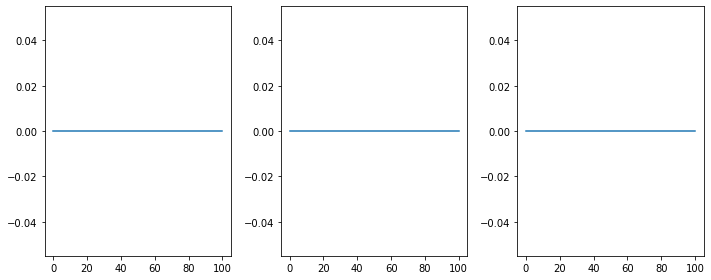

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
axes[0].plot(np.arange(len(epoch_accuracy[0])), epoch_accuracy[0])
axes[1].plot(np.arange(len(epoch_accuracy[1])), epoch_accuracy[1])
axes[2].plot(np.arange(len(epoch_accuracy[2])), epoch_accuracy[2])
fig.tight_layout()

# **Conjunto**

In [ ]:
dataloader = DataLoader(fmd, batch_size=len(fmd), shuffle=True, num_workers=4)
images, labels = next(iter(dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)

In [ ]:
def get_ensemble(x, models):
    meta_X = list()
    for i, X in tqdm(enumerate(x)):
        outs = list()
        for m in models:
            out = forward(X.unsqueeze(0).cuda(), m)
            outs.extend(out.cpu())
        meta_X.append(hstack(outs))
    return meta_X

In [ ]:
meta_train = get_ensemble(X_train, models)
meta_test = get_ensemble(X_test, models)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
827it [00:12, 68.55it/s]
355it [00:05, 68.84it/s]


In [ ]:
# Train ensemble
model = LogisticRegression(solver='liblinear')
model.fit(meta_train, y_train)

# Get accuracy
yhat = model.predict(meta_train)
acc = accuracy_score(y_train, yhat)
print("Final Accuracy:{:1.3f}".format(acc))

Final Accuracy:0.510
